# ========================================================
# Dark URL Detection
# Adrien Manciet - Thibault Sourdeval
# ========================================================

In [1]:
#Introduction

Ce dataset est un ensemble d'url qui sont labellisés. Si le label vaut 1, l'url est dangereux, si il vaut -1, il ne l'est pas. L'objectif sera de faire un algorithme de classification des url en apprenant sur le dataset disponible. 

# =========================
# Partie 1 : Phase d'exploration
# =========================

In [2]:
#Code

Nous notons que les fichiers de données sont sous la forme de matrices sparse. Cela signifie que seules les valeurs non nulles sont gardées en mémoire. 
Cela permet d'épargner des erreurs de mémoire. 

Le fichier features contient des numéros qui semblent correspondre à des subdivisions de l'url contenant en blocs. Exemple : la première ligne du fichier features affiche 4, ce qui pourrait correspondre aux quatres premiers caractères de l'url 'http'. 

Nous codons une fonction de prévisualisation pour mieux comprendre la structure des données en les transformant en un dataframe. Pour la suite, 
nous resterons dans le format de données initial.

**Fonction de prévisualisation** 

In [2]:
from sklearn.datasets import load_svmlight_file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def preview_data(day, nb_lines, nb_cols, random = True):
    # Si random est laissé tel quel, une valeur au hasard 
    # est prise pour la première ligne et la première colonne à afficher

    path =f"url_svmlight/url_svmlight/Day{day}.svm"
    X, y = load_svmlight_file(path)
    print(X.shape)

    if random == True:
        start_line = np.random.randint(0, len(y)-nb_lines)
        start_col = np.random.randint(0,X.shape[1])
    else : 
        start_line = int(input("Première ligne à afficher : "))
        start_col = int(input("Première colonne à afficher : "))
    
    label_list = []
    for i in range(start_col, start_col+nb_cols):
        label_list.append(i)

    X_df = pd.DataFrame(X[start_line: start_line+nb_lines, start_col: start_col+nb_cols].toarray(), columns=label_list)
    y_df = pd.DataFrame(y[start_line: start_line+nb_lines], columns=['label'])

    data = pd.concat([X_df, y_df], axis=1)
    return data

preview_data(15, 10, 10, random=True)


(20000, 3231924)


,1136653,1136654,1136655,1136656,1136657,1136658,1136659,1136660,1136661,1136662,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0


**Visualisations grahiques** 

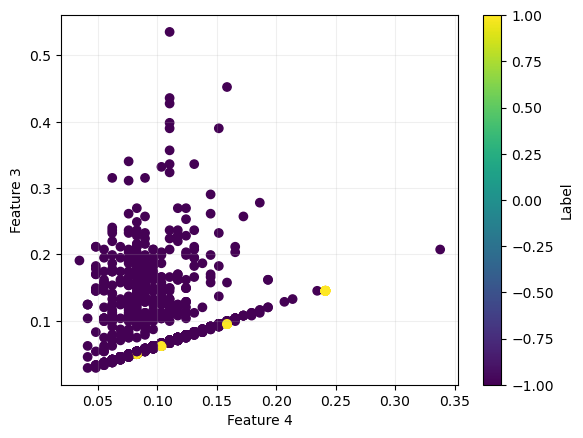

In [4]:
def scatter_plot(day, feature_x, feature_y): 
    path =f"url_svmlight/url_svmlight/Day{day}.svm"
    X, y = load_svmlight_file(path)

    X = X[0:1000,:1000].toarray()
    plt.figure()
    plt.grid(alpha=0.2)
    sc = plt.scatter(X[:,feature_x], X[:,feature_y], c=y[0:1000], cmap="viridis")
    plt.xlabel(f'Feature {feature_x}')
    plt.ylabel(f'Feature {feature_y}')
    

    cbar = plt.colorbar(sc)
    cbar.set_label("Label")
    plt.show()

scatter_plot(11,4,3)

# =========================
# Partie 2 : Feature Engineering
# =========================

In [5]:
#Code



Nous commençons par une pca brute pour voir ce que cela peut donner. 

**PCA**

In [6]:
from sklearn.decomposition import TruncatedSVD

X, y = load_svmlight_file('url_svmlight/url_svmlight/Day96.svm')

svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)
# print(X_svd.shape)


[0.01397283 0.10636171]


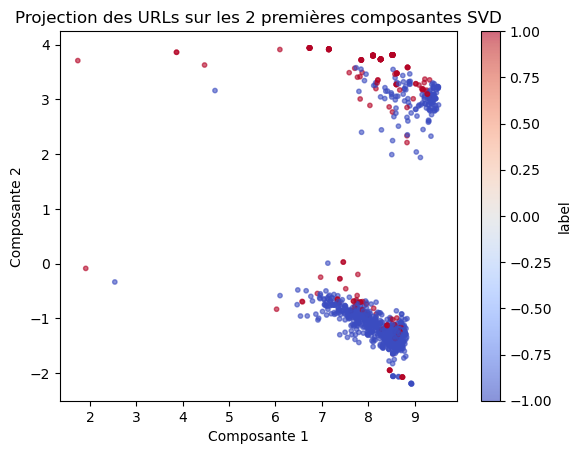

In [7]:
print(svd.explained_variance_ratio_)
plt.scatter(X_svd[:1000,0], X_svd[:1000,1], c=y[:1000], cmap='coolwarm', s=10, alpha=0.6)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.title('Projection des URLs sur les 2 premières composantes SVD')
plt.colorbar(label='label')
plt.show()

In [8]:
A = np.zeros((2,3))
print(A)

[[0. 0. 0.]
 [0. 0. 0.]]


Constatant l'efficacité toute relative de cette PCA, nous décidons de retravailler sur les données d'entrées afin d'éliminer dès le départ des features à trop faible variance.
Nous remarquons que beaucoup de colonnes sont nulles sur la prévisualisation, il faut les retirer du dataset. 
La difficulté est de parcourir tous les fichiers svm. 

Comme beaucoup de nos colonnes de features ne contiennent que des 0 ou des 1, et que cela ne permettra pas la classification, nous décidons d'enlever ces colonnes dans les données qui serveront à l'apprentissage. 

Pour ce faire, nous utilisons un critère sur la variance minimale d'une colonne dans chaque fichier. Puis, nous regardons le nombre de fichier pour lesquels une colonne a été gardée. Nous mesurons cela en pourcentage. Exemple : la colonne 1 a une variance supérieure au critère minimal dans les fichiers 1 à 10, mais pas dans les fichiers 11 à 20. Ainsi, l'algorithme a gardé la colonne un pour les fichiers 1 à 10 et l'a enlevée dans les autres. Au total, la colonne 1 a été gardée dans 50% des cas.

Dans un premier temps, nous gardons les colonnes dès lors qu'elles sont gardées au moins une fois, soit que leur pourcentage d'apparition est strictement positif. Nous pourrons raffiner cela pour garder moins de features si on voit que cela améliore la performance de la méthode d'apprentissage.

In [18]:
from sklearn.feature_selection import VarianceThreshold
import os

data_dir = "url_svmlight/url_svmlight"
X_list, y_list = [], []



selector = VarianceThreshold(threshold=0.01)

for file in sorted(os.listdir(data_dir))[:10]:  # exemple sur 10 jours
    X, y = load_svmlight_file(os.path.join(data_dir, file))
    # print('passage')
    X_list.append(X)
    y_list.append(y)


kept_mask = []
for i in range(len(X_list)):
    X_reduced = selector.fit_transform(X_list[i])
    print(X_list[i].shape, "→", X_reduced.shape)
    keep_mask = selector.get_support()
    kept_mask.append(np.where(keep_mask)[0])


(16000, 3231949) → (16000, 478)
(20000, 3231955) → (20000, 502)
(20000, 3231953) → (20000, 492)
(20000, 3231958) → (20000, 509)
(20000, 3231958) → (20000, 524)
(20000, 3231943) → (20000, 531)
(20000, 3231958) → (20000, 529)
(20000, 3231958) → (20000, 483)
(20000, 3231924) → (20000, 475)
(20000, 3231939) → (20000, 469)


In [3]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import load_svmlight_file
import os

data_dir = "url_svmlight/url_svmlight"
X_list, y_list = [], []

max_features = 3300000  # à adapter à ton dataset

selector = VarianceThreshold(threshold=0.01)
kept_mask_list = []

# Boucle sur les fichiers
for file in sorted(os.listdir(data_dir))[:10]:  # exemple sur 10 jours
    X, y = load_svmlight_file(os.path.join(data_dir, file), n_features=max_features)
    X_list.append(X)
    y_list.append(y)

    X_reduced = selector.fit_transform(X)
    keep_mask = selector.get_support()  # booléen : True si la colonne est gardée
    kept_mask_list.append(keep_mask)

# Transformer en matrice 2D : fichiers × colonnes
kept_mask_matrix = np.array(kept_mask_list, dtype=int)

# Pourcentage de fois où chaque colonne est gardée
column_keep_percentage = kept_mask_matrix.mean(axis=0) * 100

# Créer DataFrame en ne gardant que les colonnes qui ont été sélectionnées au moins une fois
df_keep = pd.DataFrame({
    'column_index': np.arange(len(column_keep_percentage)),
    'percent_kept': column_keep_percentage
})

# Filtrer les colonnes jamais gardées
df_keep = df_keep[df_keep['percent_kept'] > 0]
# Trier par pourcentage décroissant si tu veux
# df_keep = df_keep.sort_values(by='percent_kept', ascending=False).reset_index(drop=True)

# Afficher un aperçu
# print(df_keep.head(30))



Sélection des données d'entraînement :

In [4]:
import scipy.sparse as sp

selected_columns = df_keep['column_index'].values

X_filtered_list, y_filtered_list = [],[]

for file in sorted(os.listdir(data_dir))[:10]:
    X,y = load_svmlight_file(os.path.join(data_dir, file), n_features=max_features)

    X_filtered = X[:,selected_columns]
    X_filtered_list.append(X_filtered)
    y_filtered_list.append(y)


X_all = sp.vstack(X_filtered_list)
y_all = np.concatenate(y_filtered_list)

**PCA sur les données filtrées**

In [13]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# X_reduced_scaled = StandardScaler().fit_transform(X_reduced)

# pca = PCA(n_components=2)
# pca.fit(X_reduced_scaled)
# X_reduced_proj = pca.transform(X_reduced_scaled)
# print(pca.explained_variance_ratio_)

# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.scatter(X_reduced[:,15], X_reduced[:,16],c = y, cmap='viridis', alpha=0.5)
# plt.grid(alpha=0.2)
# plt.title('Dans les coordonées de base')
# plt.colorbar(label='label')

# plt.subplot(1,2,2)
# plt.scatter(X_reduced_proj[:,0], X_reduced_proj[:,1], c = y, cmap='viridis', alpha=0.5)
# plt.xlabel('Première composante principale')
# plt.ylabel('Deuxième composante principale')
# plt.colorbar(label='label')
# plt.grid(alpha=0.2)

# plt.show()



# =========================
# Partie 3 : Phase d'apprentissage
# =========================

In [ ]:
#Code

Commençons par un svm naïf. 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Entraînement pur :

In [6]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


svm = LinearSVC(random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)

print('Précision de : ', accuracy_score(y_test, y_pred))
print("\nRésumé de classification:\n", classification_report(y_test, y_pred))
print("\nMatrice de confusion:\n", confusion_matrix(y_test,y_pred))

Précision de :  0.9761734693877551

Résumé de classification:
               precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98     25216
         1.0       0.97      0.97      0.97     13984

    accuracy                           0.98     39200
   macro avg       0.97      0.97      0.97     39200
weighted avg       0.98      0.98      0.98     39200


Matrice de confusion:
 [[24738   478]
 [  456 13528]]


Tentative de validation croisée : 

In [7]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    MaxAbsScaler(),           # scaler rapide pour sparse matrices
    LinearSVC(
        dual=False,           # plus rapide si n_samples > n_features
        max_iter=3000,        # limite d'itérations
        tol=1e-3,             # tolérance plus élevée pour converger plus vite
        random_state=42
    )
)

In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_all, y_all, cv=4, n_jobs=-1)

print("Scores sur les folds :", scores)
print("Précision moyenne :", np.mean(scores))
print("Écart-type :", np.std(scores))

Scores sur les folds : [0.96865306 0.96973469 0.97681633 0.9787551 ]
Précision moyenne : 0.9734897959183674
Écart-type : 0.004367036990718132


**SVM avec un kernel non linéaire**

In [11]:

from sklearn.svm import SVC
# Pipeline pour gérer le sparse matrix
model = make_pipeline(
    MaxAbsScaler(),                # scaler rapide compatible sparse
    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)  # kernel RBF
)

# Cross-validation sur un échantillon réduit pour tester
sample_idx = np.random.choice(X_all.shape[0], size=100_000, replace=False)
X_sample = X_all[sample_idx]
y_sample = y_all[sample_idx]

scores = cross_val_score(model, X_sample, y_sample, cv=3, n_jobs=-1)
print("Scores CV :", scores)
print("Précision moyenne :", np.mean(scores))
print("Écart-type :", np.std(scores))


Scores CV : [0.9751305  0.97503975 0.97512975]
Précision moyenne : 0.975099999695023
Écart-type : 4.260377567128916e-05


Nous constatons une légère amélioration de la précision obtenue avec un kernek rbf. Néanmoins, le temps de calcul est nettement plus long. Vu la taille du jeu de données qu'on souhaite tester, il n'est pas envisageable de prendre le rbf tel quel. Il pourrait convenir si on avait moins de features. Mais, dans ce cas, n'aurait-on pas un soucis de nombre de samples par rapport au nombre de features ? 

Etant donné qu'on obtient des résultats satisfaisants avec le svm linéaire, une bonne précision, sans surapprentissage (nous l'avons vérifié avec la validation croisée), il paraît assez optimal de continuer avec le svm linéaire. Quel paramètre peut-on ajuster pour la suite ? 

Peut-être faut-il interroger le nombre de features sélectionné avec le critère sur la variance ? Nous souhaitions aussi implémenter une autre technique de sélection de variable consistant à évaluer la pertinence d'une feature sur la prédiction de classe du sample (avec un test du chi2 par exemple). 

# =========================
# Partie 4 : Tuning d'un hyperparamètre
# =========================

In [ ]:
#Code

# =========================
# Partie 5 : Conclusions
# =========================

In [ ]:
#Code